# MadMiner physics tutorial (part 4C)

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

## 0. Preparations

In [1]:
import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import InformationGeometry

In [2]:
# MadMiner output
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

Let's look at a simple example to understand what happens in information geometry. At first we note that the Fisher Information is a symmetric positive definite rank two tensor, and therefore can be seen as a Riemanian metric. It can therefore be used to calculate distances between points in parameter space.

Previously, in tutorial 4b, we have considered the **local distance** $d_{local}(\theta,\theta_0)$ between two points $\theta$ and $\theta_0$. It is defined in the tangent space of $\theta_0$, where the metric is constant and hence flat, and can simply be calculated as $d_{local}(\theta,\theta_0) = I_{ij}(\theta_0) \times (\theta-\theta_0)^i (\theta-\theta_0)^j$. 

Going beyond this local approximation, we can calculate a **global distance** $d_{global}(\theta,\theta_0)$ which takes into account the fact that the information is not constant throughout the parameter space. Using our knowledge from general relativity, this distance is defined as
\begin{equation}
 d(\theta,\theta_0)= \text{min} \int_{\theta_0}^{\theta} ds \sqrt{I_{ij}(\theta(s)) \frac{d\theta^i}{ds}\frac{d\theta^j}{ds}} 
\end{equation}
where $\theta(s)$ is the geodesic (the shortest path) connecting $\theta_0$ and $\theta$. This path is follows the geodesic equation 
\begin{equation}
 \frac{d^2\theta^i}{ds^2} = - \Gamma^i_{jk} \frac{d\theta^j}{ds}\frac{d\theta^k}{ds} \quad \text{with} \quad
 \Gamma^i_{jk} = \frac{1}{2} I^{im} \Big(\frac{\partial I_{mk}}{\partial \theta^j} + \frac{\partial I_{mj}}{\partial \theta^k} - \frac{\partial I_{jk}}{\partial \theta^m}\Big) \quad \text{and} \quad I^{im} I_{mj} = \delta^i_j \ . 
\end{equation}
In practice, we obtain the geodesics by numerically integrating the geodesic equation, starting at a parameter point $\theta_0$ with a velocity $\theta'_0=(\theta/ds)_0$

## 1. Stand-alone Example

In the following, we consider a sample geometry with Fisher Information $I_{ij}(\theta)= (( 1+\theta_1/4 , 1 ),( 1 ,  2-\theta_2/2))$ and determine the geodesics and distance contours for illustration. At first, we initialize a new class `InformationGeometry` and define the Fisher Information via the function `information_from_formula()`.

In [3]:
formula = "np.array([[1 + 0.25*theta[0], 1], [1, 2 - 0.5*theta[1]]])"

infogeo = InformationGeometry()
infogeo.information_from_formula(formula=formula, dimension=2)

Now we obtain one particular geodesic path staring at $\theta_0$ in the direction of $\Delta \theta_0$ using the function `find_trajectory()`.   

In [4]:
thetas, distances = infogeo.find_trajectory(
    theta0=np.array([0.0, 0.0]),
    dtheta0=np.array([1.0, 1.0]),
    limits=np.array([[-1.0, 1.0], [-1.0, 1.0]]),
    stepsize=0.025,
)

For comparison, let's do the same for a constant Fisher Information $I_{ij}(\theta)=I_{ij}(\theta_0)=((1,1),(1,2))$.

In [5]:
formula_lin = "np.array([[1 ,1],[1, 2 ]])"
infogeo_lin = InformationGeometry()
infogeo_lin.information_from_formula(formula=formula_lin, dimension=2)
thetas_lin, distances_lin = infogeo_lin.find_trajectory(
    theta0=np.array([0.0, 0.0]),
    dtheta0=np.array([1.0, 1.0]),
    limits=np.array([[-1.0, 1.0], [-1.0, 1.0]]),
    stepsize=0.025,
)

/Users/giovannidecrescenzo/Desktop/PhD_stuff/MadMiner/madminer/fisherinformation/geometry.py:260: RuntimeWarning: divide by zero encountered in scalar divide
  max_stepsize = 0.05 * np.linalg.norm(dtheta) / np.linalg.norm(ddtheta)


and plot the results

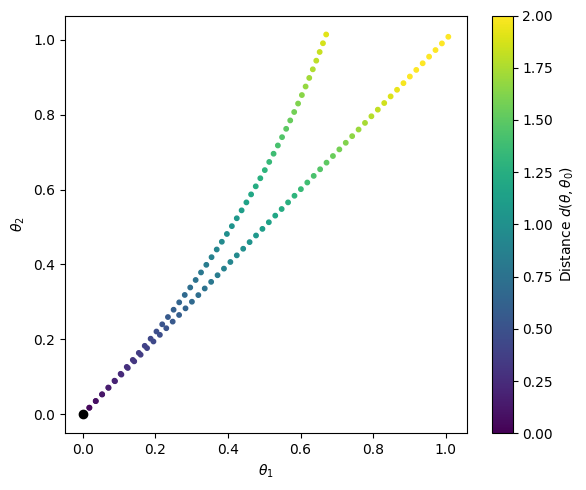

In [6]:
cmin, cmax = 0.0, 2
fig = plt.figure(figsize=(6, 5))

plt.scatter(
    thetas_lin.T[0],
    thetas_lin.T[1],
    c=distances_lin,
    s=10.0,
    cmap="viridis",
    marker="o",
    vmin=cmin,
    vmax=cmax,
)
sc = plt.scatter(
    thetas.T[0],
    thetas.T[1],
    c=distances,
    s=10.0,
    cmap="viridis",
    marker="o",
    vmin=cmin,
    vmax=cmax,
)
plt.scatter([0], [0], c="k")

cb = plt.colorbar(sc)
cb.set_label(r"Distance $d(\theta,\theta_0)$")

plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.tight_layout()
plt.show()

We can see that the geodesic trajectory is curved. The colorbar denotes the distance from the origin.  

Let us now see how we can construct the distance contours using the function `distance_contours`. 

In [7]:
grid_ranges = [(-1, 1.0), (-1, 1.0)]
grid_resolutions = [25, 25]

theta_grid, p_values, distance_grid, (thetas, distances) = infogeo.distance_contours(
    np.array([0.0, 0.0]),
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    stepsize=0.08,
    ntrajectories=30,
    continous_sampling=True,
    return_trajectories=True,
)

and plot the results

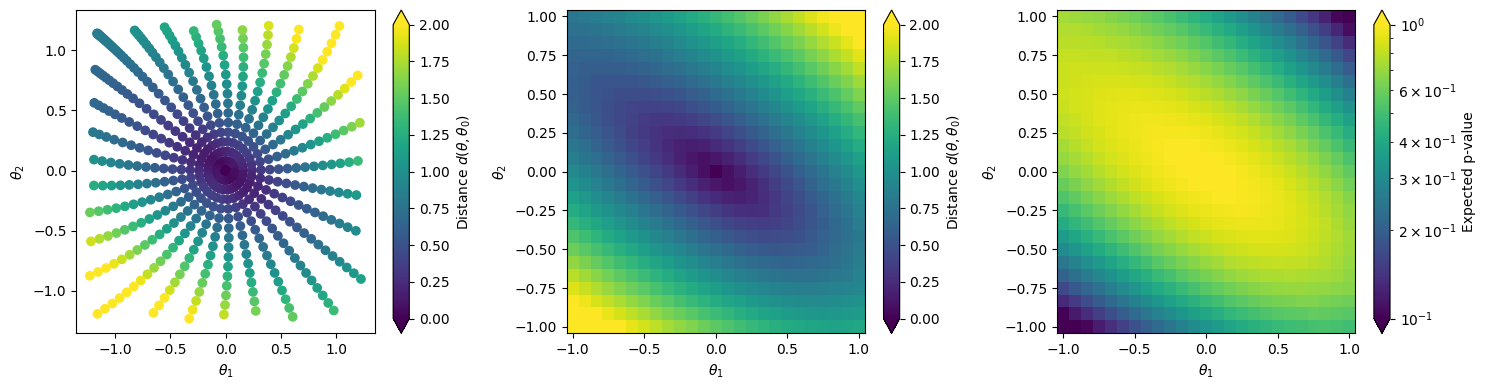

In [8]:
# Prepare Plot
cmin = 0.0
cmax = 2
fig = plt.figure(figsize=(15.0, 4.0))

bin_size = (grid_ranges[0][1] - grid_ranges[0][0]) / (grid_resolutions[0] - 1)
edges = np.linspace(
    grid_ranges[0][0] - bin_size / 2,
    grid_ranges[0][1] + bin_size / 2,
    grid_resolutions[0] + 1,
)
centers = np.linspace(
    grid_ranges[0][0],
    grid_ranges[0][1],
    grid_resolutions[0],
)

# Plot
ax = plt.subplot(1, 3, 1)
sc = ax.scatter(
    thetas.T[0],
    thetas.T[1],
    c=distances,
    vmin=cmin,
    vmax=cmax,
)
cb = plt.colorbar(sc, ax=ax, extend="both")
cb.set_label(r"Distance $d(\theta,\theta_0)$")
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")


ax = plt.subplot(1, 3, 2)
cm = ax.pcolormesh(
    edges,
    edges,
    distance_grid.reshape((grid_resolutions[0], grid_resolutions[1])).T,
    vmin=cmin,
    vmax=cmax,
    cmap="viridis",
)
cb = plt.colorbar(cm, ax=ax, extend="both")
cb.set_label(r"Distance $d(\theta,\theta_0)$")
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")


ax = plt.subplot(1, 3, 3)
cm = ax.pcolormesh(
    edges,
    edges,
    p_values.reshape((grid_resolutions[0], grid_resolutions[1])).T,
    norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=1),
    cmap="viridis",
)
cb = plt.colorbar(cm, ax=ax, extend="both")
cb.set_label("Expected p-value")
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")


plt.tight_layout()
plt.show()

The left plot shows the distance values along generated geodesics. These values are interpolated into a continuous function shown in the middle plot. In the right plot we convert the distances into expected p-values. 

## 2. Information Geometry Bounds for Example Process 

Now that we understand how Information Geometry works in principle, let's apply it to our example process. Let's first create a grid of theta values

In [9]:
def make_theta_grid(theta_ranges, resolutions):
    theta_each = []
    for resolution, (theta_min, theta_max) in zip(resolutions, theta_ranges):
        theta_each.append(np.linspace(theta_min, theta_max, resolution))

    theta_grid_each = np.meshgrid(*theta_each, indexing="ij")
    theta_grid_each = [theta.flatten() for theta in theta_grid_each]
    theta_grid = np.vstack(theta_grid_each).T
    return theta_grid


grid_ranges = [(-1, 1.0), (-1, 1.0)]
grid_resolutions = [25, 25]
theta_grid = make_theta_grid(grid_ranges, grid_resolutions)

Now we create a grid of Fisher Informations. Since this might take some time, we already prepared the results, which can be loaded directly.

In [10]:
model = "alices"
calculate_fisher_grid = False
if calculate_fisher_grid:
    fisher = FisherInformation("data/lhe_data_shuffled.h5")
    fisher_grid = []

    for theta in theta_grid:
        fisher_info, _ = fisher.full_information(
            theta=theta,
            model_file=f"models/{model}",
            luminosity=300.0 * 1000.0,
            include_xsec_info=False,
        )
        fisher_grid.append(fisher_info)
    np.save(f"limits/infogeo_thetagrid_{model}.npy", theta_grid)
    np.save(f"limits/infogeo_fishergrid_{model}.npy", fisher_grid)
else:
    theta_grid = np.load(f"limits/infogeo_thetagrid_{model}.npy")
    fisher_grid = np.load(f"limits/infogeo_fishergrid_{model}.npy")

In the next step, we initialize the `InformationGeometry` class using this input data. Using the function `information_from_grid()`, the provided grid is interpolated using a piecewise linear function and the information can be calculated at every point.

In [11]:
infogeo = InformationGeometry()
infogeo.information_from_grid(
    theta_grid=f"limits/infogeo_thetagrid_{model}.npy",
    fisherinformation_grid=f"limits/infogeo_fishergrid_{model}.npy",
)

14:21 madminer.utils.vario INFO      Loading limits/infogeo_thetagrid_alices.npy into RAM
14:21 madminer.utils.vario INFO      Loading limits/infogeo_fishergrid_alices.npy into RAM


As before, we can now obtain the p-values using the `distance_contours()` function

In [12]:
theta_grid, p_values_infogeo, distance_grid, (thetas, distances) = infogeo.distance_contours(
    np.array([0.0, 0.0]),
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    stepsize=0.05,
    ntrajectories=300,
    return_trajectories=True,
)

and plot it again

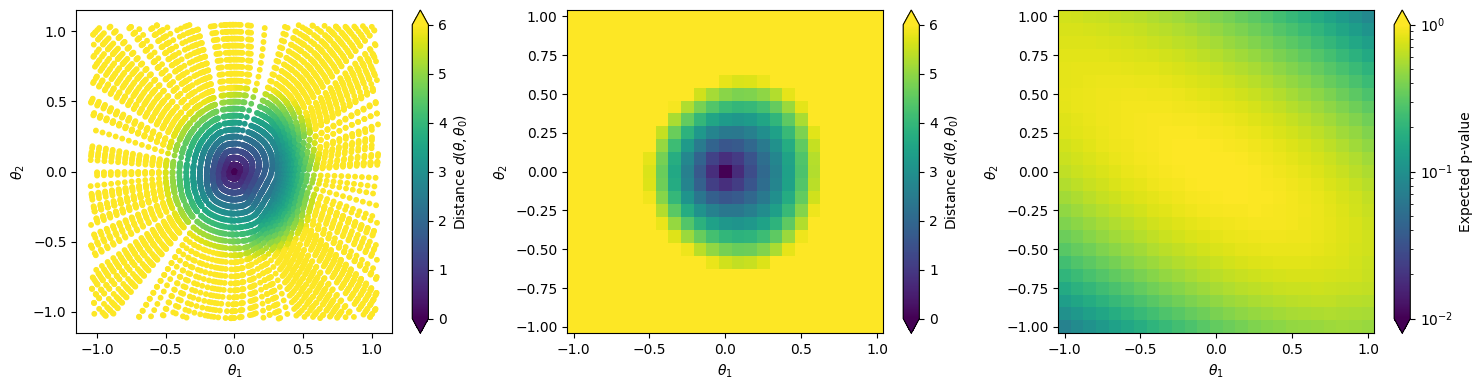

In [13]:
# Prepare Plot
cmin = 0.0
cmax = 6
fig = plt.figure(figsize=(15.0, 4.0))

bin_size = (grid_ranges[0][1] - grid_ranges[0][0]) / (grid_resolutions[0] - 1)
edges = np.linspace(
    grid_ranges[0][0] - bin_size / 2,
    grid_ranges[0][1] + bin_size / 2,
    grid_resolutions[0] + 1,
)
centers = np.linspace(
    grid_ranges[0][0],
    grid_ranges[0][1],
    grid_resolutions[0],
)

# Plot
ax = plt.subplot(1, 3, 1)
sc = ax.scatter(
    thetas.T[0],
    thetas.T[1],
    c=distances,
    vmin=cmin,
    vmax=cmax,
    s=10,
)
cb = plt.colorbar(sc, ax=ax, extend="both")
cb.set_label(r"Distance $d(\theta,\theta_0)$")
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")


ax = plt.subplot(1, 3, 2)
cm = ax.pcolormesh(
    edges,
    edges,
    distance_grid.reshape((grid_resolutions[0], grid_resolutions[1])).T,
    vmin=cmin,
    vmax=cmax,
    cmap="viridis",
)
cb = plt.colorbar(cm, ax=ax, extend="both")
cb.set_label(r"Distance $d(\theta,\theta_0)$")
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")


ax = plt.subplot(1, 3, 3)
cm = ax.pcolormesh(
    edges,
    edges,
    p_values.reshape((grid_resolutions[0], grid_resolutions[1])).T,
    norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=1),
    cmap="viridis",
)
cb = plt.colorbar(cm, ax=ax, extend="both")
cb.set_label("Expected p-value")
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")


plt.tight_layout()
plt.show()

## 3. Compare to other results

Load previous results and add Information Geometry results

In [16]:
[p_values, mle] = np.load("limits/limits.npy", allow_pickle=True)

p_values["InfoGeo"] = p_values_infogeo.flatten()
mle["InfoGeo"] = 312

UnicodeError: Unpickling a python object failed: UnicodeDecodeError('ascii', b'\x8dcO\x1d\xb3/=;\xf56\xbb4\xd3\xf3v;\x85\x9b\xb5\xa6Td\xa7;\x04\x1e\x1b\xeb\x84\xe2\xce;5g\xdbz@v\xeb;\x8f\x12\x8b\x1d\xa6\x9a\x01<\x00\x98\x0bo\x98\xbb\x11<\x7f\xb9s\xccj\xc8\x1e<R^E \xcd\x1d)<]\t\xfc+\xb6\xa84<\xc4\xf9\x90\xeb\xe2\xd4A<\x8c\x9fz\xe2\xd2\x1dP<V\xeck8\x97\xe8\\<\xd1\xc6\x06\xbc\x08!g<\x7f\xc6\x91YK\x86l<(L\x00\xec\x89,g<!\xcbn?\xea\xd6U<\xab\xd3\xd5\x90\xd0\x856<\x92\xa7\xea?\xd5L\n<X\xb5T\x9d\x87\xae\xd3;\\0=\x80\x9a\xbb\x96;1\nh\xdb\xd4\xdbX;\x96\'C\xcf\xc7\xca\x1e;9\xaf/Z\x94l\xe8:\x0e\xb1\xfe\x9b\xe6,\xba:\xb9c\xc5\xf5\x0c\x82\x9b;L\xa2\xf7m\x87\x80\xd9;\xd6\xa5G2\xda\x19\x10<\x1f\xcd\xb7\xc7\xc6\xd3:<\t{^\xa8k\xd4]<\xf4\x14w\x88>1w<\\\xe1\xf8\x9d\xb7\x13\x8b<H\x98>\xed\xb6\xce\x99<\xbc\xaa\xfa\x9a\x84\xd7\xa5<@l_ \x8c\xa4\xb1<\x90G\x93\xacI\x88\xbc<\x9d\xe3\x0e\xc6\xb5[\xc7<E\x05b\xb4\xf0\xb3\xd2<\x13Uz\x82\xc6\xf8\xda<\xc6!B\xf0?\x0b\xdf<Qm\x9e\xc4\x08\xec\xd8<\x9c\xf5\xf7\xbd.\xe7\xc8<\xb7=\x1a\xf6\xf34\xad<k\xcfwF\x8bv\x84<\xbfB\x00\x9fI\xccR<lu\x9dA|-\x1a<\xe1\xb5\xa63\xc4=\xe0;F\xc5\x10\xb5\xe7\xba\xa4;g\xb5\x86\x17\xe0#n;\xa6\xa5*K\xd7S:;\xef\x94\xdf\r9\x96\xf6;\x0b\xa5\xe9\xdd7\xc56<\xdb\xdcop\x94\xd8p<\x91n?\xa0\xfe0\xa1<Q\xa7UM \xba\xc7<\xba\xab\xe6*\xe0\x91\xe6<\x99Z\xd3\x8b{\x1a\xff<\xeeB\x07\x943\xa5\x10=.\x96m\xe9*\xe7\x1d=@)\xd2\n\x89=(=\x85\x1c\x0ey\xf9\xbc2=T\xa3h\x10@U<=p=\x8f&\xa8\xa5D=\x15\x828\x14/[K=\x9f\xe7\xc7\x9f\x0e\xecM=@\xa7\x9b~\xbe\x13H=\xc7\xdb\xa6\n\xef\xaa9=\x90\xb2\x93\t\x93\x01!=\x0c\x810\x03)\xf3\xfb<\xbd\xf1\xff\xbc\xd4I\xce<\xfc\xc5\x0f\xe3\xa9\x1d\x98<\xe1\x19\n\x87A\x08`<5\x06Ol(\x15$<g\xfc\xe5\x8cy\x17\xea;\xe3\x00\xe4\xa3\xfe\xcb\xb2;\xec\xad\x95 l\x83P<\x0cp|\xd3\xed\x90\x90<\xc7\n\xc9\xb4\x03\x9b\xca<\xe5\x1b\x07\xaf\xf4v\xff<\xdaA3\xdc\xdc\x1c*=z\xdev\x88\xe6\x14N=\xd0(8\xa8\x14\x9dh=R\xc9\x18\xb5\xc1\x11~=\x18z\xa7\xab\x88J\x8d=v\xcc\x8f|Ee\x98=!\'N\x89$u\xa2=S\x0c\xf7#H^\xaa=\x9a\xd6\xdb\xd9\xab\xde\xb1=\xdfD\x0eC\x15.\xb6=\x0c\x96R\'7j\xb7=p\xa8J\x07n\x0c\xb3=\x15W\xf3\x19\x1f\xa1\xa5=\xd5\xe6\xdd\x04\x95\xe8\x8f=t,\x9c\xe1\xdf\xe3m=M\xd8\x89\xc3L^B=\x86w\xb5\x7fJ\x05\x10=\xa4\xca\xde\x017\x06\xd6<\x0b\x91\xecq_\xa6\x9a<?\xde\xb4\x8f\x0cl_<\xe3\xfcg/\xc5\xb3#<\xbbA\xba$\xe5\x06\xa6<\xb2\x1d9ki|\xe4<&\x17X\xd9>| =r\x1c\x8bX\xfd\xfdT=[\xc2Z\xbf\x9c\xcc\x83=\xbd65\xab\x8e\xaa\xaa=_\xce\x98\x035\x87\xc9={c\x93(#\xd3\xe1=tg7J\x8d\x12\xf3=$\xd3\xe1\x9a^\xa4\x00>\x87\xc7\xec\xa7"7\t>\xc7\xa9\xf1\xe9\xbek\x11>\x99\x7f\xa6\x1fxr\x16>\xc9\xa5i\xf6\xa1\x94\x1a>+\x98jAKg\x1b>\x90\x84\x9d\xd3+\x98\x16>\xf2\x86\x1bD\x80\x14\x0b>k\xc6\x8b_)\xc7\xf5=\xe4\xf1\xf6\xbc\x1e\x91\xd6=\xc6\x95\xa4N\xb4p\xae=\xe3\x1bU\x0c\xb1S|=(\xd2\x83Pb\xf2C=\x9e&\xcd\x902\xb7\x07=&\n\x91\x8d\x9b\xa1\xca<>\xa1\xc5\x06\x18m\x8f<\xf8nWY(\xf9\xfa<_\'\x80\xfcl\xa26=\x18}\'\x0c\x019q=:\xd4\x1d\xaa\xaf\xef\xa5=\x80W\x10u+\xdb\xd5=\x8c?\xe37I3\x00>{\x04\xbb\xca\xe3h!>/\x1a\xa4c\xee1;>]\x99\xb7\xf4\xb5\xcfO>\xd2\xc5\xee\xa2\xf7O]>\x9a\xbfV\xcbE\x98f>\x1d\xee\xdd\x978\xcdn>\xe1\xb2\xc4}\x18<s>v\x0f\x9d\x0c\x95\x0ev>\x99hF\xa2n[v>\xa4Gd\xb6\x98\x9ar>\xb9\x9a\x95$\xe1*g>\x11\xf9\x9fF3\xd1S>\xf6\x83\x12{H\x186>\x92V\xe2\xe4\x96\xfe\x0f>\xeadJ\xc1/\x8a\xdf=\xa2h\xaf\xea\xb0\x19\xa7=z\x0b\x97nr\x1al=\x9f(\t?\x9c\x000=\x12\xd7\x1a\xd1\x03+\xf3<\x986\xf6\xa35\x9bM=\x06\xdd\xda\x08\xdb\x0e\x87=\xa9\x18\x9e\xec\xf7\\\xc0=\x92\x8c\xe7\x94\xca\xd5\xf3=D\xbf\xb1\xb9\xacq#>S\x8bJq\xbejM>\x8a\xe6b\xe6\x87\x9ap>Q\xa3\x8d\x80\xba\x9e\x8b>S\xb4\xe7\xd1?&\xa1>m\x81\x89\x1dj\x80\xb0>zZ}_\x05\xf5\xb9>\xc7:\x00\x9b\xc6\xa6\xc1>%Li\xf8\x1f\xa8\xc5>\xd2l\x9e\xe71G\xc8>\xf6o\x8e\xa5\xee4\xc8>\xf0\xfe\x9bGV\x1b\xc4>]\xee&\xed\xb1w\xb9>2-/\xc3\xab\x91\xa6>\xd44\x10\xd6\x92u\x8a>C1\xd8(\x88Yd>\xbb\xc0\x96\xcaKo5>"V\x02\xcd\xec\xd1\x00>\'\x80\x93\x14S\xee\xc5=Ldu\xa9P\xb5\x8a=\xadL\x11x\xc6\x00Q=no\x10\xa8\x06\xad\x9b=\xc6K\xbdG\xfbn\xd5=\xce\xad\xe3!\x8bl\r>\x9d-\xf7\x9e"\xdf@>\xe5\xbc\xc0b\xd8\x1bo>#2\xde\x16q`\x96>#MZ\x98\xa4\x85\xb8>\x0bm\xe1\x91k7\xd4>y\x86\x94\x06\xdb:\xe9>VqY\x12(\x80\xf8>\x82f\xb4Ts^\x03?,#g\xa5\x82?\n?\x8e\xaf\x07\x0fJ\xc9\x0f?\xed\r`U\xcav\x11?E5\x01\x1cu\x07\x11?\xd1\xbe\xfe5S\xc5\x0b?\xd3\xd1v\x11\xc5r\x01?\x13l\x1ckA8\xef>\xf7\xbaR\xc2\xb9\xe7\xd2>d\xff\xccbM\xd1\xae>\x1d\xa5\x80/a\x9b\x81>\x01_1\x92\xe6sN>o\xae\xfb\x84\xdb\xf3\x15>\xedO^=Z4\xdd=2\xd0g\xd2A\xbd\xa3=\xb0\xf2\xd3(9\xc3\xe4=b\x8b\x1cP\xdd\x1c!>\xa9\xc5\xfd\xa26:X>vS/\xec\xf9N\x8b>\xa5EX\r/\xa3\xb7>F\xbb\xce\xdd1\x08\xdf>\xcd0\xb61#\xd7\xfe>\x05\x06=\xf4CS\x17?\xc1]yH&D+?\xd6[:p\x15Y9?\x06\x9b\xd0\xa2\x16\x83C?\xf1#f\xcaH\xfbI?\xdf\xc6\x10Z\x9e\xeeN?\xc6\xfb\x9b=@\x9aP?\xe4\x17DP:YO?d\x98\xd1\x06\xd5\x9dH?\xdb\xb3\xc5\xa1p\xf0=?\xff\xcf\x95Q/o*?\xf7\x17\x1e\x02\xe7R\x10?\xacg\x86\x84\x125\xec>\xcbE\x0b9C\xaa\xc1>$\xf9{\xecF\x08\x91>N\xf5D+I/[>i\x15K!\xfa]#>\xf3\x1c\xee\xae\xa8\x87\xea=\x05M\x08P}\xfb\'>\xbc\xe4\x01\xcb2`e>e\xbbW\xcc[J\xa0>\t]%\xc8I\x04\xd3>>~q\x1a\xb9\x06\x00?\xf6\x06\x99\xb6\xb9B#?|^\xb8\xa4\xe8\xce@?\xfc\x10Rs\xb2\tV?z\xc3r\x1bo\xa0f?5S\xd2&\x92\x08s?\x94+\x9d\xe2\x06o{?7\x14\xc3t\x02\x92\x81?\x14\x02\xed\xc5\xe0a\x84?\xa9\\YTVB\x85?\xbfG$|)A\x83??\x974<\xcb\xaf|?\xd9 \xb9\xde:\x97p?=!\x89\xec\x9e\x82\\?8\x19\xce<8\xd6A?\xb7.j?\xe4T ?I\xf0\x19P\x8eg\xf6>\x03\xc1\x0c\x1cQ\xd3\xc7>A\xb1\xafO%s\x94>\xdf!l\xf0\r\xb0]>\xe8\xb2\xa2u\xefA#>\xbf\xc5\x18\xe9\x823e>N\xf9\x1c\x97G/\xa3>ms\xda7@\x96\xde>"\xe1\xda\x93\xed\xb7\x12?\xbaD\xe7\x0cY\xde??\xb6\xbd\x13\xa0\xbd\'b?\x12%H\xca\x074|?\\u\xfb\x8ag\xa2\x8f?\xf4S\xac\x06B\xa1\x9b?\xb6\x1c\x9c\xb7\xedC\xa4?\xf4:`\xa0\xdf\x88\xaa?\xd5T\x99~+\x10\xb0?\xd2F\xfa1d\t\xb2?\xc1\r\x1d\x16\xa9A\xb2?\x9f\xf9\xc7\x01\xc9\xb3\xaf?(\x1d\x9d\x153_\xa6?\xef\xb6w\x01\x13\x9d\x98?\x11\xaaEOs\xa9\x84?J^\x8b\x93\xbf]j?\x04\xbe\xef\x8d\xb3\xadI?\x9bQ\xc8\xdc\xbd(#?]\x9e\xbb~1\xf4\xf5>\xc9\x13\x97\xae\xeaw\xc3>D!\xd7S\x94\\\x8b>lq\x1a_S\xf2O>A\xaf\xac\xc6\xf3[\x9d>\xa6\x84\xeb\xe4m\xec\xd7>\xcbX1d^\xcd\x11?\xe1\xe6\xd6\x00\x88?E?\xeeK\xa6\xb5\xd6\xeeq?1b\xaa\x02\xf7\xce\x93?3h/7Vr\xac?l\x07\xf8\xd5\x17,\xbc?(\xa1Z\x9f\xffB\xc5?\xc1\xa7$\xe9\xc9>\xcb?\xb9\xb9p+&$\xd0?\xe9\xc8\xc0\xc5\xa1n\xd2?\xf4\xc9&\xfb)\x19\xd4?\xfa\x83h\x98G\xec\xd3?\xc3,Z\xfb\x9e\xd5\xd0?\x04\x98kM\xbd\x01\xc7?\x94C\x81\x17\xde\xc9\xb8?/$?Q}\x06\xa5?\x96\x8ctKv;\x8c?\xc0\\\xee\t\xd6\xd9m?\x9b\xe0\xf2\\\rPH?0x\xa6t+\x9f\x1d?f\\n&\xc0\x84\xea>tix\xcfR\xaa\xb1>\xbf\xe4\xbeA\x9asr>\xe5/O\x0f\xfa2\xd0>\xd6\xbe\xc5-\xfcG\x05?\xf2u\xd0\xb0\xa5q9?\x85@\xc9e\xba\x89i?3\xcbO\xae\xa8<\x93? 2\xeb\xab\x97\xbd\xb3?0\xb0\x95\x05E\x89\xca?\x1b\x8b\x13\x03B=\xd8?tb \xc13\x9e\xe0?\x82bW\xca\xbe`\xe3?\xff\x9ci\x01H[\xe5?\x9d\x170\xe0\x10j\xe7?\xd8@m\x0cz,\xe9?\x0c\xd0\x7f\x7f\x9f\xf2\xe8?\x10\x98\xa9+S3\xe5?\xb4\xf6\xa3`4v\xdd?\xa2l:5\xe3\x8e\xd0?\xe1c\x0c\x19\xbal\xbe?\xeb%\xba\xf9\x86\xea\xa6?\xb7\xc72Q\xc4\x9b\x8b?\x88\x8f\xfe\xab\xb9Ci?\x18?p\x88:\x97@?\xa1\xfb\xec\xd5\xf4C\x0e?$\xe2\x8a\xc5Lp\xd3>\xd6I\xe9v\x90\xcb\x92>\xdb\x87\xa1.\x1b\xab\xfb>;\x12\x86\xb8m`,?\xefr\x134M\xc1X?\xb1\x13\x9f\n\xd1\x12\x82?\xe7zL\xaf=\xd9\xa4?L%\xdc\xb4\xb9\xac\xc1?>O\x08\x17\xc8\x05\xd5?\xf1\x0fBO\xbd\xc0\xe1?\x1e\x99\xed\x02-\xfb\xe6?H\x0e\xd4\xcca\x94\xe9?w\xd1\xf2\xfe\x15?\xeb?\xf6\x15V\x9c7]\xed?\xe4\xec\xf8\xbf\xfc\x9e\xef?\x00\x00\x00\x00\x00\x00\xf0?\xb1X$|\xcbt\xec?^G\xae\xd4Zq\xe5?p\x83\x0b\xa2\x8e`\xdb?n\xd6\xa9\xc4D\xe6\xcd?\xfb\x15\tW\xb9\x85\xbb?z\xa0\xe6\xa8\xd22\xa4?\'1\x93Hy\xbd\x85?\xac\xee\xc5vt\xbb_?Y\xbd\r\xd3\x1cA.?\x99\xbe\xdf\x0f\xecO\xf3>\xee\xa4\xf7\xa7\x9e\xfe\xb1>y\t\xf1\x82i\xbd ?\xeey74{\xe1L?\xdb\x8e*\xd3\x9a\xf0r?\x87\xa8\x1e\xe2\xa2_\x93?u\xacj\x9d9\x06\xaf?\xb4\xfc2EV,\xc3?\xa9x\xc8\xfat\x10\xd2?*\xa6}\xee#Q\xda?\xfa\x9e\xe8"mS\xdf?;\x1a\xf9\xe0\xf6\x9d\xe0?\xa2\x8a\xf9\xb2\xd5 \xe1?\xe7\x0c.\x18,\x00\xe2?\xdajq\x8eN&\xe3?|\x9a.\x14K\xb1\xe3?#\x92\xb4-\x99\xad\xe2?(\xbc\xfe\n\xd2\x06\xe0?TG\x95\x19\x88\xf5\xd8?f\x81\n\'\x08\x83\xd1?\x14e\xecB{\x14\xc5?\xdeg>bu\xc7\xb3?\x18\x8b\xa08\xec\xc7\x99?\xe3y\x01\xec$Ku?^ze\xf8Z\x96E?"\xb6\x1dJ\xe7\x05\x0c?\xe1\x84\x0c\x96D\xec\xc9>\x8c_q\xb4\xd1\x849?W!\xed\xa2@se?E\xce\xe9r\xdf\xac\x88?\x94#\xf5\xf0m\xe3\xa3?@+}\x88\x9a9\xb7?\xcc`\x17\x06^g\xc4?rb\xafg\x11\x1d\xcc?`\xd3\xbb/Q\xe8\xcf?\\\t\x88\xb8\x13\xb2\xcf?\xb8\xbf\x8cV\x80\x82\xcd?\x80\xf7\xe4IR`\xcb?~\xbf]\x1f|3\xca?\xbd\xe0\xff\x82\xc1\xe0\xc9?H\xf8 ,\xf9\xd2\xc9?\xe3XO\xe3\xf8\x91\xc9?j\xa6B\x18\xce\x08\xc9?0\xcc\t^\x11\x1d\xc8?\xc7\x94jp\xe6\xfa\xc5?\xd7R\xdf\xc5\xd2G\xc1?\xc3\x1e\xf6Ipz\xb4?n\x01\xa1\xcc\xdc\xe2\x9f?\t\xfaY\x11\x07\xb4}?\xb1qc\x9e\xed<P?/\x11\x803\xcf\x1f\x16?\x0c%\xfe\xd4\x806\xd5>~k\x9b\xd0\x9f5F?\xdb\xb2\xd3\xfav\xd7t?EM\xd8<\x92n\x99?\xf2e[\xf8\xa0\xe4\xb3?\x152\xcdI\xc8S\xc4?\x93\xa7\n\x18X\x8e\xcc?b\xb6}\xdb`\xc9\xcd?\xc9EC\xecqL\xc9?\xe42Lh\x808\xc3?\x8eF\xa7*ha\xbc? \x18\x8b\xe2~\xa1\xb5?A,\xf9\xcb_\x95\xb1?\x00\xa80\xc4\xdc\xbc\xae?\x0c\xb7\x94\x8d\xb8\xc8\xac?\xb8\xfc\x07D:\xcd\xac?\xbf\x1a\xe2\xe4\x7f\xb0\xae?\x0e\x86\xc7v\x1b\xfe\xb0?\x8c\xf0t\x1dy<\xb2?\x99\xd3\t\x8b\x04\xca\xb0?\x13\xc6\xe3\x1c\x84\xca\xa6?)\x81\xcae\x05\xdb\x93?\xdb`\xc5\xc7\xaeft?E\x1e\x87\xc5\x0e\x86H?:\x05\xe9\xa5\x1co\x12?4\xb6\x14qc\x91\xd3>\xa2v(\xc6\xa4\x05E?\xf7W\xf3<\\\xbav?\xa5\xe8n\xf1\x154\xa0?O\x8eQ\xd1\xb9\x9f\xbc?\xbe=0\xb9\x8b\xa6\xce?\xb8 \xaf\xae\xcby\xd4?\xb5\xb0+\xcb\xc0z\xd2?3\xae2Ui^\xc9?c\xc0\xf2\x8dwU\xbe?\xdf\xa8\x88>\xa3\xe8\xb1?\x1d\xfc\xb4\xf6\xa2\xe3\xa6?\xfd\x85\xa2U\x00\x95\xa0?\x9c\x01\x8e\\\xe8`\x9b?=\xe9\x88\xc9/I\x99?O\x0e\xfa\xa8Z\x7f\x99?\xf7K\xb1\x83\x9eZ\x9b?\xacki\xcd{\xfc\x9d?.*\xdc\xdc\xd28\x9f?\x0b\xbc\xc2\xf8\xe5\xa2\x9b?\xc2\x05\xa8\xe9\x02>\x92?\x8bC\xe5\xca\x08\xf1\x7f?\xd5\xe7\xf1\x98GHa?\xce\xbbo\xc1{\xfc6?\xfb\xdc\'\xc6q\xe7\x03?\x98\xfav\x10\xac\xea\xc8>p\x0bdY\xcf\x056?e\xb6A\r@\x86h?\xe8\x00\xb6&\xf6\x10\x93?\x85\xd1\xd3\x0c\xb5\xca\xb2?\x80\xf32 \x05&\xc6?\x8e\x94T\x05{#\xcf?2;\x83\xd4\x1d\xcb\xcb?\x86\x06\r\\H\xce\xc1?\xb7\x8fO\xd8\xe3>\xb3?\x05\xf9`\xbc*\xb3\xa4?*\x9a]8\xc05\x99?lm\x87UB\x87\x92?\xd5|\xe0\xe3aQ\x90?\x82\r\x8aj\xcdC\x90?\x9d\x08\x13J\xd1\x10\x91?\x8a\x00\xf1\'\x07\xb7\x91?;\xf5E\xaf[R\x91?\x1b"\xa8\xfd2O\x8e?"\xc7\x17\xe5\x86*\x86?\xdd\xa0\x94\xaa\x9a\xf2x?\n\xc1b&\xbf\xf7c?a\xe0\xde\x00\x15\x9aE?\xf1vW\xcb\x17a\x1f?\xb3TQ\x0et\xde\xef>J\xd8+P\xdfz\xb8>\x8c\xff\xbe^\x80\xa9\x1c?.\xddT\x8b\x9c@K?\xed\x9a\xf3\xd8\x96\x84s?e\x9f\x96\x02\xc3\xee\x92?M\x91 \xfd\xe1\x0b\xa7?\xd2*\x02\xca\xa8%\xb1?\x8a\xdbO\xdd\\3\xb0?)\xb1\x05\x18(\x95\xa5?\xb0\x18\xe9\x85\xa1\xb6\x97?\x1d\xdag\xbb\x96\xa4\x89?!\xf7\x1efB\xcb\x7f?\xbd/\xc0^U\xa6x?\x82"bK\x83\xe2w?\xee\xef#$7\xc7z?\x9fB\x93\xb0\xb8\xfa~?\xab\xde\xb6\xf5Q\x9d\x80?\xcf=\xf2\xd9\'\xae~?\x180Y\x93\x0cVw?\x8f3\xe5\xfc\xc5\\l?\x83mu\xa8\r\xb6Z?\x8a\xc1\x97#W\xeaB?\xc2\x08\xbd\xb4X\xc2#?\xc8\x84i1\xeb\x88\xfe>\x0c\x0f\x7f\x94\xe6\xfd\xd1>\xab$\xf1\xf92\x19\xa1>0\x8b\x11k \xb0\xfc>9\xd0\x07o\x86k$?\xef\x15\xf3o&\xe7G?\xcd\xad\xb6k\xab\xc3d?1\x85\xb6:\xd0\x97x?\xbdm\x01r\x8e\xeb\x82?\x869x\x82\x07\x04\x83?\x9f(\xc5\xd0\xd7\xc2z?Jc\x12\xd6\xf8\x01n?\xd5\x9f\xe3\xa7\xbb\xb4_?\xe1\x86P\xe1:\xabR?\xf3\xe5QK#\xaeK?\xe9\xb2\xc6K \xd6J?!\xbc\xb9\x1a\xc9\x10P?\n\xe7EZd\xe4T?\xbce\x07`XcY?\x15\xdc\xbe\xcb\xbdrY?\xb35\x0f\x98^\x83S?\x93\xe1x#\x9d<F?\xdas\x8fb\xe8\xd82?7\xa9\xcb\xba\x0e%\x18?}\x8bI\xf4 \xf0\xf7>\x948\x02#H\xf0\xd2>\xfaQo$#\xdc\xa8>\xcfa\xec\xed\x8cc|>7f\x80q\xa5\xa0\xda>(\xf0s\xad\x02B\xfc>\x05$\xdc\x1d\xbe&\x1b?\x9c\x19\x0b1\x91K5?\x86\xab\x9e\r\xb1\xaaH?iu\x89I\x1a\x88S?\xbeI\x9d\xc5\nxT?\x8f\xce_{\x02BM?\xc0+h%\\{??\xaeO\xefo\x99\xcd-?\r+\xa7\x9f\x9f\xc3\x1d?\xe3\x82\x85s-i\x12?(\xb9\xfe*\xe1\xe4\x0e?\x82\xbb\xe1=Xb\x11?\xabr.\xa9\xb0z\x17?\xba73\xdf,\x02 ?\x94\x12O=\xf7x"?\xd7\x94\xbc\x15\xd5\xa1\x1f?\x8e\xf5a\x0e\xc7\xd8\x12?\xe8 \x94M\x1e7\xff>5B\xf0\xc3\x0b\xbf\xe2>\x0e\x0f$\x1d}l\xc1>\xfa\x85"\xf9\xa4\xe4\x9a>\x10\xfb\xd7P\xb9hr>\xfe\xf6?J\x84\xafG>\xce{Wy2|\xb6>\xb2\x7f\xb9t\x9dT\xd3>J\x00\x93k_\x8e\xf0>Z\x1b\xef\x9c\xac\x1e\t?\x86j[\x1f\xaf\xca\x1d?\xd0\x05X\x1b\xf8\xc0(?a\xafc\xe6\xf5\xf0*?3vc\xde\xe5+#?\x02Ei\xb5\x95?\x13?\xea@q\xa2\xb3\x97\xff>\x1b\xe7r\x91\xf0\xa4\xe9>d\xc1=\x0e\x8f\xdc\xd8>^\x08\xb1\xa9os\xd0>\xa5\xee\xda\xea\xb3\xca\xce>z\xbe\xed\xe4\x02\xdb\xd2>f\x89\xae\x7f8\x8d\xd9>\x80\x0e*\xc2\xa8?\xdf>\xa6\x92\xb4\xb5\xdf\xd7\xdc>\xd2\xf5\xd3\xc6\xdd\xff\xd1>\xce\xc3\xa5\xfa\xe5\x90\xbd>R(&\xf9\xe4\xb4\xa0>P\x93\xe0{\xd8m|>\xab\x94\xb0R\xc4DT>"\x16\xa0U&\xcc*>\xe0b\xfe\x17\x16\xd5\x01>G7\x95>\xdc\x9e\x8a>D\xd2\x0cU\x89C\xa4>\x9f\xed\xfb\xbe\xaa\xb5\xc0>$R\x7f}O\xf9\xd9>,\xb7g0\x88\\\xf0>F\xf0t\r\xfa(\xfd>C#\xb1\xb9\x15\xc5\x00?gA\xfakF]\xf8>\xc90\xc6\xefa\xc7\xe7>\xd5\xf9%\x96\x81\xeb\xd1>\t\xb43S\xe69\xb9>B\xee\x8e\xa0\xb23\xa4>z\x03?]\x07s\x95>\xad\x99\xca\xf8\xe0\x16\x90>\xfb\x89\xb0\x1c\xf5A\x90>-\xb5\xfe\x03\xb3\x17\x93>\x9e;\x16\xeeTF\x95>\x13>\x08)~v\x92>X\x0b\xc39f\xb9\x85>\xd3\xf0\xe0\x87\xaatp>\xfdo\xe85\xb3\x9dP>\xf8\xad\xf4OY\xae(>0O\x92\xa2\xbd\xb5\xfe=?z\xec\x87\x05=\xd2=\xca\xf0\\@;\x11\xa7=G>\xbc(}\x87O>\xb1\xd4\xef1\xa0>f>K\xe9\x80\xc32\x1a\x82>\xec\xc8\x93\xe5R\xf8\x9c>\x87G\xe7\x15\xbd>\xb3>\xf7_:\xc7\xe5C\xc2>\xd2\x9b\x91\xe43_\xc6>\x05\x8b{\xd0M-\xc1>:\x9f\x023#v\xb1>\xef\xca}Y=\xc7\x9a>\x07\xd7?W\xde\x88\x82>\xb0f\xf7\x94B\xedk>U\x83\xf0\x16\xe2\x8aZ>S\x8dPw\xdd\x05Q>v\xb6r)\xb3yL>\x9a\xda \xd3mKK>\x03\xcb\x98\xb7\x05\xdbH>e\xed\xa7\xd0+\xc2A>b\xa4\x81\x17?G1>\xd9d4\xb7\xed\x97\x15>\x9a\x8an\x0e\x0c\xe0\xf1=(\x85-X\x08\xb6\xc5=\xa0\x8d\x1c\xc6\xbfL\x96=Q\xb36\xaa\x96zf=\xd2\xaa\xa5\xd0\x15O9=', 0, 1, 'ordinal not in range(128)')
You may need to pass the encoding= option to numpy.load

and plot them together with the obtained Information Geometry results

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

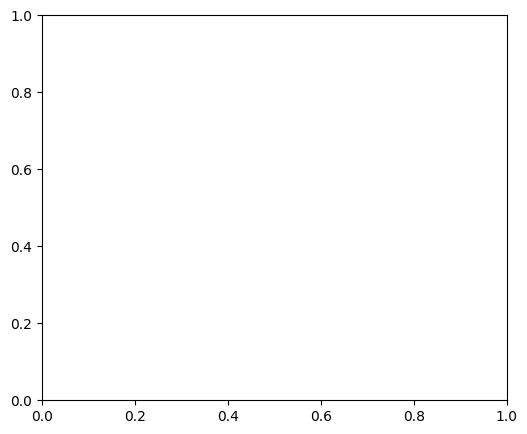

In [17]:
show = "InfoGeo"

bin_size = (grid_ranges[0][1] - grid_ranges[0][0]) / (grid_resolutions[0] - 1)
edges = np.linspace(
    grid_ranges[0][0] - bin_size / 2,
    grid_ranges[0][1] + bin_size / 2,
    grid_resolutions[0] + 1,
)
centers = np.linspace(
    grid_ranges[0][0],
    grid_ranges[0][1],
    grid_resolutions[0],
)

fig = plt.figure(figsize=(6, 5))
ax = plt.gca()

cmin = 1.0e-2
cmax = 1.0

pcm = ax.pcolormesh(
    edges,
    edges,
    p_values[show].reshape((grid_resolutions[0], grid_resolutions[1])).T,
    norm=matplotlib.colors.LogNorm(vmin=cmin, vmax=cmax),
    cmap="Greys_r",
)
cbar = fig.colorbar(pcm, ax=ax, extend="both")

for i, (label, p_value) in enumerate(p_values.items()):
    plt.contour(
        centers,
        centers,
        p_value.reshape((grid_resolutions[0], grid_resolutions[1])).T,
        levels=[0.32],
        linestyles="-",
        colors=f"C{i}",
    )
    plt.scatter(
        theta_grid[mle[label]][0],
        theta_grid[mle[label]][1],
        s=80.0,
        color=f"C{i}",
        marker="*",
        label=label,
    )

plt.legend()

plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
cbar.set_label(f"Expected p-value ({show})")

plt.tight_layout()
plt.show()

Finally, we compare the obtained distance $d(\theta,\theta_0)$ with the expected log-likelihood ratio $q(\theta,\theta_0) = E[-2 \log r(x|\theta,\theta_0)|\theta_0]$. We can see that there is an approximately linear relationship. 

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

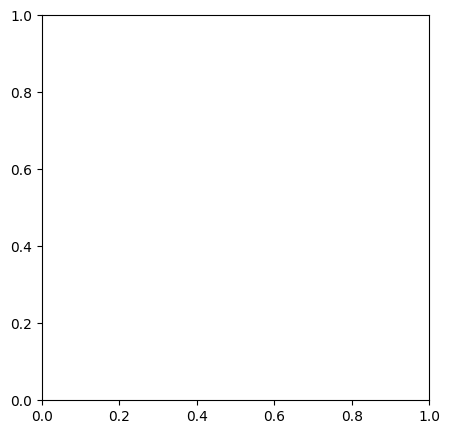

In [18]:
from scipy.stats.distributions import chi2

# Prepare Plot
cmin = 0.0
cmax = 6
fig = plt.figure(figsize=(5.0, 5.0))

# Plot
ax = plt.subplot(1, 1, 1)
ax.scatter(
    chi2.ppf(1 - p_values["ALICES"], df=2),
    distance_grid.flatten() ** 2,
    c="red",
)
ax.set_xlabel(r"$q(\theta,\theta_0)$ (ALICES)")
ax.set_ylabel(r"$d^2(\theta,\theta_0)$ ")
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)

plt.tight_layout()
plt.show()